# Image Features
We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

In [3]:
import random
import numpy as np
from exercise_code.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk. However, we don't apply our previous preprocessing steps, as we want to extract custom features later on.

In [1]:
from exercise_code.data_utils import load_CIFAR10
from exercise_code.vis_utils import visualize_cifar10

def get_CIFAR10_data(num_training=48000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for feature extraction and training.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/'
    X, y = load_CIFAR10(cifar10_dir)
    

    # Our training set will be the first num_train points from the original
    # training set.
    mask = range(num_training)
    X_train = X[mask]
    y_train = y[mask]
    
    # Our validation set will be num_validation points from the original
    # training set.
    mask = range(num_training, num_training + num_validation)
    X_val = X[mask]
    y_val = y[mask]
    
    # We use a small subset of the training set as our test set.
    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    X_test = X[mask]
    y_test = y[mask]

    return X, y, X_train, y_train, X_val, y_val, X_test, y_test

# Invoke the above function to get our data.
X_raw, y_raw, X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# visualize raw data
visualize_cifar10(X_raw, y_raw)

Train data shape:  (48000, 32, 32, 3)
Train labels shape:  (48000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [2]:
from exercise_code.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
print(X_train_feats)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000/48000 images
Done extracting features for 2000/48000 images
Done extracting features for 3000/48000 images
Done extracting features for 4000/48000 images
Done extracting features for 5000/48000 images
Done extracting features for 6000/48000 images
Done extracting features for 7000/48000 images
Done extracting features for 8000/48000 images
Done extracting features for 9000/48000 images
Done extracting features for 10000/48000 images
Done extracting features for 11000/48000 images
Done extracting features for 12000/48000 images
Done extracting features for 13000/48000 images
Done extracting features for 14000/48000 images
Done extracting features for 15000/48000 images
Done extracting features for 16000/48000 images
Done extracting features for 17000/48000 images
Done extracting features for 18000/48000 images
Done extracting features for 19000/48000 images
Done extracting features for 20000/48000 images
Done extracting features for 21000/48000 images
D

## Train a Softmax classifier on features
Using the multiclass Softmax code developed earlier in the assignment, train a Softmax classifier on top of the features extracted above; this should achieve better results than training the classifier directly on top of raw pixels.

In [3]:
# Use the validation set to tune the learning rate and regularization strength

from exercise_code.classifiers.softmax import SoftmaxClassifier

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [1e5, 1e6, 1e7]

results = {}
best_val = -1
best_softmax = None


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the Softmax; save#
# the best trained classifer in best_softmax. You might also want to play      #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for learning_rate in learning_rates:
    for reg in regularization_strengths:
        softmax = SoftmaxClassifier()
        loss_hist = softmax.train(X_train_feats, y_train, learning_rate=learning_rate, reg=reg,
                      num_iters=20000, verbose=True)
        y_train_pred = softmax.predict(X_train_feats)
        trainingAccuracy = np.mean(y_train == y_train_pred)
        print('training accuracy: %f' % trainingAccuracy, )
        y_val_pred = softmax.predict(X_val_feats)
        validationAccuracy = np.mean(y_val == y_val_pred)
        print('validation accuracy: %f' % validationAccuracy, )
        results[(learning_rate, reg)] = (trainingAccuracy, validationAccuracy)
        if validationAccuracy > best_val:
            best_val = validationAccuracy
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
          lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during validation: %f' % best_val)

iteration 0 / 20000: loss 76.405783
iteration 100 / 20000: loss 74.938387
iteration 200 / 20000: loss 73.499552
iteration 300 / 20000: loss 72.089572
iteration 400 / 20000: loss 70.708654
iteration 500 / 20000: loss 69.352866
iteration 600 / 20000: loss 68.025428
iteration 700 / 20000: loss 66.724836
iteration 800 / 20000: loss 65.447751
iteration 900 / 20000: loss 64.198931
iteration 1000 / 20000: loss 62.971697
iteration 1100 / 20000: loss 61.771295
iteration 1200 / 20000: loss 60.592941
iteration 1300 / 20000: loss 59.440573
iteration 1400 / 20000: loss 58.307605
iteration 1500 / 20000: loss 57.198081
iteration 1600 / 20000: loss 56.111409
iteration 1700 / 20000: loss 55.045322
iteration 1800 / 20000: loss 54.002407
iteration 1900 / 20000: loss 52.978141
iteration 2000 / 20000: loss 51.974489
iteration 2100 / 20000: loss 50.989424
iteration 2200 / 20000: loss 50.026509
iteration 2300 / 20000: loss 49.081029
iteration 2400 / 20000: loss 48.155716
iteration 2500 / 20000: loss 47.24786

iteration 900 / 20000: loss 123.768494
iteration 1000 / 20000: loss 101.740888
iteration 1100 / 20000: loss 83.707900
iteration 1200 / 20000: loss 68.944246
iteration 1300 / 20000: loss 56.859139
iteration 1400 / 20000: loss 46.964590
iteration 1500 / 20000: loss 38.865469
iteration 1600 / 20000: loss 32.234634
iteration 1700 / 20000: loss 26.806529
iteration 1800 / 20000: loss 22.362828
iteration 1900 / 20000: loss 18.724512
iteration 2000 / 20000: loss 15.746634
iteration 2100 / 20000: loss 13.308450
iteration 2200 / 20000: loss 11.312380
iteration 2300 / 20000: loss 9.678553
iteration 2400 / 20000: loss 8.340864
iteration 2500 / 20000: loss 7.245807
iteration 2600 / 20000: loss 6.349324
iteration 2700 / 20000: loss 5.615579
iteration 2800 / 20000: loss 5.014737
iteration 2900 / 20000: loss 4.522837
iteration 3000 / 20000: loss 4.120240
iteration 3100 / 20000: loss 3.790599
iteration 3200 / 20000: loss 3.520722
iteration 3300 / 20000: loss 3.299835
iteration 3400 / 20000: loss 3.1190

iteration 2200 / 20000: loss 2.302585
iteration 2300 / 20000: loss 2.302585
iteration 2400 / 20000: loss 2.302585
iteration 2500 / 20000: loss 2.302585
iteration 2600 / 20000: loss 2.302585
iteration 2700 / 20000: loss 2.302585
iteration 2800 / 20000: loss 2.302585
iteration 2900 / 20000: loss 2.302585
iteration 3000 / 20000: loss 2.302585
iteration 3100 / 20000: loss 2.302585
iteration 3200 / 20000: loss 2.302585
iteration 3300 / 20000: loss 2.302585
iteration 3400 / 20000: loss 2.302585
iteration 3500 / 20000: loss 2.302585
iteration 3600 / 20000: loss 2.302585
iteration 3700 / 20000: loss 2.302585
iteration 3800 / 20000: loss 2.302585
iteration 3900 / 20000: loss 2.302585
iteration 4000 / 20000: loss 2.302585
iteration 4100 / 20000: loss 2.302585
iteration 4200 / 20000: loss 2.302585
iteration 4300 / 20000: loss 2.302585
iteration 4400 / 20000: loss 2.302585
iteration 4500 / 20000: loss 2.302585
iteration 4600 / 20000: loss 2.302585
iteration 4700 / 20000: loss 2.302585
iteration 48

iteration 3600 / 20000: loss 2.359983
iteration 3700 / 20000: loss 2.349587
iteration 3800 / 20000: loss 2.341052
iteration 3900 / 20000: loss 2.334098
iteration 4000 / 20000: loss 2.328384
iteration 4100 / 20000: loss 2.323680
iteration 4200 / 20000: loss 2.319882
iteration 4300 / 20000: loss 2.316734
iteration 4400 / 20000: loss 2.314153
iteration 4500 / 20000: loss 2.312053
iteration 4600 / 20000: loss 2.310330
iteration 4700 / 20000: loss 2.308934
iteration 4800 / 20000: loss 2.307788
iteration 4900 / 20000: loss 2.306834
iteration 5000 / 20000: loss 2.306072
iteration 5100 / 20000: loss 2.305436
iteration 5200 / 20000: loss 2.304926
iteration 5300 / 20000: loss 2.304493
iteration 5400 / 20000: loss 2.304148
iteration 5500 / 20000: loss 2.303862
iteration 5600 / 20000: loss 2.303631
iteration 5700 / 20000: loss 2.303434
iteration 5800 / 20000: loss 2.303286
iteration 5900 / 20000: loss 2.303159
iteration 6000 / 20000: loss 2.303055
iteration 6100 / 20000: loss 2.302964
iteration 62

iteration 4800 / 20000: loss 2.302585
iteration 4900 / 20000: loss 2.302585
iteration 5000 / 20000: loss 2.302585
iteration 5100 / 20000: loss 2.302585
iteration 5200 / 20000: loss 2.302585
iteration 5300 / 20000: loss 2.302585
iteration 5400 / 20000: loss 2.302585
iteration 5500 / 20000: loss 2.302585
iteration 5600 / 20000: loss 2.302585
iteration 5700 / 20000: loss 2.302585
iteration 5800 / 20000: loss 2.302585
iteration 5900 / 20000: loss 2.302585
iteration 6000 / 20000: loss 2.302585
iteration 6100 / 20000: loss 2.302585
iteration 6200 / 20000: loss 2.302585
iteration 6300 / 20000: loss 2.302585
iteration 6400 / 20000: loss 2.302585
iteration 6500 / 20000: loss 2.302585
iteration 6600 / 20000: loss 2.302585
iteration 6700 / 20000: loss 2.302585
iteration 6800 / 20000: loss 2.302585
iteration 6900 / 20000: loss 2.302585
iteration 7000 / 20000: loss 2.302585
iteration 7100 / 20000: loss 2.302585
iteration 7200 / 20000: loss 2.302585
iteration 7300 / 20000: loss 2.302585
iteration 74

iteration 6000 / 20000: loss 2.302585
iteration 6100 / 20000: loss 2.302585
iteration 6200 / 20000: loss 2.302585
iteration 6300 / 20000: loss 2.302585
iteration 6400 / 20000: loss 2.302585
iteration 6500 / 20000: loss 2.302585
iteration 6600 / 20000: loss 2.302585
iteration 6700 / 20000: loss 2.302585
iteration 6800 / 20000: loss 2.302585
iteration 6900 / 20000: loss 2.302585
iteration 7000 / 20000: loss 2.302585
iteration 7100 / 20000: loss 2.302585
iteration 7200 / 20000: loss 2.302585
iteration 7300 / 20000: loss 2.302585
iteration 7400 / 20000: loss 2.302585
iteration 7500 / 20000: loss 2.302585
iteration 7600 / 20000: loss 2.302585
iteration 7700 / 20000: loss 2.302585
iteration 7800 / 20000: loss 2.302585
iteration 7900 / 20000: loss 2.302585
iteration 8000 / 20000: loss 2.302585
iteration 8100 / 20000: loss 2.302585
iteration 8200 / 20000: loss 2.302585
iteration 8300 / 20000: loss 2.302585
iteration 8400 / 20000: loss 2.302585
iteration 8500 / 20000: loss 2.302585
iteration 86

iteration 7400 / 20000: loss 2.302581
iteration 7500 / 20000: loss 2.302581
iteration 7600 / 20000: loss 2.302582
iteration 7700 / 20000: loss 2.302582
iteration 7800 / 20000: loss 2.302581
iteration 7900 / 20000: loss 2.302582
iteration 8000 / 20000: loss 2.302581
iteration 8100 / 20000: loss 2.302582
iteration 8200 / 20000: loss 2.302581
iteration 8300 / 20000: loss 2.302582
iteration 8400 / 20000: loss 2.302582
iteration 8500 / 20000: loss 2.302581
iteration 8600 / 20000: loss 2.302582
iteration 8700 / 20000: loss 2.302582
iteration 8800 / 20000: loss 2.302582
iteration 8900 / 20000: loss 2.302581
iteration 9000 / 20000: loss 2.302581
iteration 9100 / 20000: loss 2.302581
iteration 9200 / 20000: loss 2.302581
iteration 9300 / 20000: loss 2.302581
iteration 9400 / 20000: loss 2.302583
iteration 9500 / 20000: loss 2.302581
iteration 9600 / 20000: loss 2.302581
iteration 9700 / 20000: loss 2.302582
iteration 9800 / 20000: loss 2.302581
iteration 9900 / 20000: loss 2.302581
iteration 10

iteration 8600 / 20000: loss 2.302585
iteration 8700 / 20000: loss 2.302585
iteration 8800 / 20000: loss 2.302585
iteration 8900 / 20000: loss 2.302585
iteration 9000 / 20000: loss 2.302585
iteration 9100 / 20000: loss 2.302585
iteration 9200 / 20000: loss 2.302585
iteration 9300 / 20000: loss 2.302585
iteration 9400 / 20000: loss 2.302585
iteration 9500 / 20000: loss 2.302585
iteration 9600 / 20000: loss 2.302585
iteration 9700 / 20000: loss 2.302585
iteration 9800 / 20000: loss 2.302585
iteration 9900 / 20000: loss 2.302585
iteration 10000 / 20000: loss 2.302585
iteration 10100 / 20000: loss 2.302585
iteration 10200 / 20000: loss 2.302585
iteration 10300 / 20000: loss 2.302585
iteration 10400 / 20000: loss 2.302585
iteration 10500 / 20000: loss 2.302585
iteration 10600 / 20000: loss 2.302585
iteration 10700 / 20000: loss 2.302585
iteration 10800 / 20000: loss 2.302585
iteration 10900 / 20000: loss 2.302585
iteration 11000 / 20000: loss 2.302585
iteration 11100 / 20000: loss 2.302585


iteration 10000 / 20000: loss 2.302585
iteration 10100 / 20000: loss 2.302585
iteration 10200 / 20000: loss 2.302585
iteration 10300 / 20000: loss 2.302585
iteration 10400 / 20000: loss 2.302585
iteration 10500 / 20000: loss 2.302585
iteration 10600 / 20000: loss 2.302585
iteration 10700 / 20000: loss 2.302585
iteration 10800 / 20000: loss 2.302585
iteration 10900 / 20000: loss 2.302585
iteration 11000 / 20000: loss 2.302585
iteration 11100 / 20000: loss 2.302585
iteration 11200 / 20000: loss 2.302585
iteration 11300 / 20000: loss 2.302585
iteration 11400 / 20000: loss 2.302585
iteration 11500 / 20000: loss 2.302585
iteration 11600 / 20000: loss 2.302585
iteration 11700 / 20000: loss 2.302585
iteration 11800 / 20000: loss 2.302585
iteration 11900 / 20000: loss 2.302585
iteration 12000 / 20000: loss 2.302585
iteration 12100 / 20000: loss 2.302585
iteration 12200 / 20000: loss 2.302585
iteration 12300 / 20000: loss 2.302585
iteration 12400 / 20000: loss 2.302585
iteration 12500 / 20000: 

In [4]:
# Evaluate your trained classifier on the test set
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.408


In [5]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    if len(idxs) > 0:
        idxs = np.random.choice(idxs, min(examples_per_class, len(idxs)), replace=False)
    else:
        idxs = []
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

NameError: name 'plt' is not defined

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Describe the misclassification results that you see. Do they make sense?</p>
    <p>**Your answer:** 
Some of them make sense also for human intuition. For example, animals on green background are classified as deer, images that show sky as plane or trucks as cars.</p>
</div>

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set.

Note that in the neural net class we have used explicit biases. In the preprocessing of this exercise we have also added a bias dimension to the input, such that we don't have to consider an explicit bias in the linear classifier above. The neural net therefore has an additional parameter in the first layer (the additional bias term), which after all does not matter, as both bias terms can be learned. So just don't get confused by this.

In [6]:
from exercise_code.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
net = TwoLayerNet(input_dim, hidden_dim, num_classes)
# Train the network
stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
num_iters=5000, batch_size=256,
learning_rate=0.9, learning_rate_decay=0.95,
reg=1e-3, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val_feats) == y_val).mean()
print('Validation accuracy: ', val_acc)

best_net = net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

5000
iteration 0 / 5000: loss 2.302585
iteration 100 / 5000: loss 1.455433
iteration 200 / 5000: loss 1.344241
iteration 300 / 5000: loss 1.312005
iteration 400 / 5000: loss 1.293542
iteration 500 / 5000: loss 1.178755
iteration 600 / 5000: loss 1.179805
iteration 700 / 5000: loss 1.140029
iteration 800 / 5000: loss 1.014460
iteration 900 / 5000: loss 1.097508
iteration 1000 / 5000: loss 0.981105
iteration 1100 / 5000: loss 1.144329
iteration 1200 / 5000: loss 0.928556
iteration 1300 / 5000: loss 0.996714
iteration 1400 / 5000: loss 0.985578
iteration 1500 / 5000: loss 1.011243
iteration 1600 / 5000: loss 1.051108
iteration 1700 / 5000: loss 0.983378
iteration 1800 / 5000: loss 0.875399
iteration 1900 / 5000: loss 0.966350
iteration 2000 / 5000: loss 1.033467
iteration 2100 / 5000: loss 0.866826
iteration 2200 / 5000: loss 0.857086
iteration 2300 / 5000: loss 0.935074
iteration 2400 / 5000: loss 0.916194
iteration 2500 / 5000: loss 0.811341
iteration 2600 / 5000: loss 0.946139
iteratio

In [10]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print("Test accuracy: ", test_acc)

Test accuracy:  0.609


## Save the model

When you are satisfied with your training, save the model for submission.

In [11]:
from exercise_code.model_savers import save_feature_neural_net
save_feature_neural_net(best_net)

## Scoring function
We will score the model you have just saved based on the classification accuracy on our test dataset. The scoring function should represent the difficulty of obtaining a good test accuracy and should therefore give 0 points for worse results than random guessing, should be linear in a first regime and exponential beyond that. The onset of exponential growth depends on the problem. In that region you get twice as many points for an additional 10% accuracy.

For this problem we specifically use the following scoring function:

$$f(x) = \left\{
	\begin{array}{ll}
		0  & \mbox{if } x \leq 0.1 \\
		100x & \mbox{if } 0.1 < x < 0.59 \\
        \left(\frac{59}{\exp(0.59 \ln(2)/0.1)}\right) \exp(x \ln(2)/0.1) & \mbox{if } 0.59 \leq x \leq 1
	\end{array}
\right.$$

The function can be plotted in the following cell.

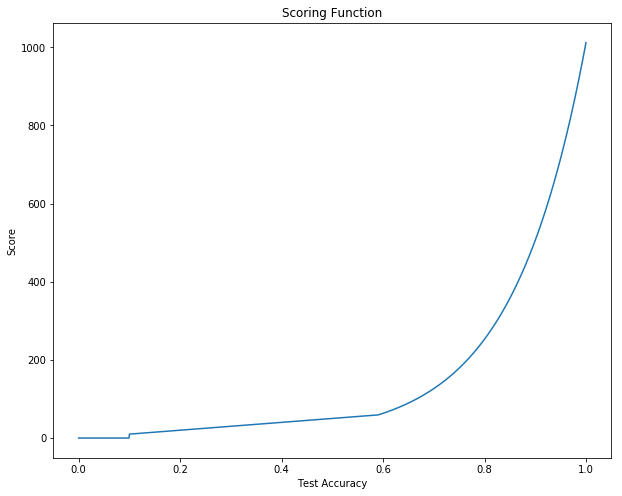

In [10]:
from exercise_code.data_utils import scoring_function

x = np.linspace(0, 1, num=1000)
plt.plot(x, scoring_function(x, lin_exp_boundary=0.59, doubling_rate=0.1))
plt.title('Scoring Function')
plt.xlabel('Test Accuracy')
plt.ylabel('Score')
plt.show()